In [8]:
pip install optuna

In [24]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier ,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, classification_report
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [10]:
df_data=pd.read_csv('data.csv', delimiter=',')
df_data

,Unnamed: 0,store_id,order_id,profit,delivery_distance,order_start_prepare,planned_prep_time,order_ready,region_id,status_id,...,items_count,order_price,day_of_week,hour_start,minutes_start,hour_start_sin,hour_start_cos,minutes_start_sin,minutes_start_cos,prepared_on_time
0,0,5014,20562761,45.5040,2205,2024-09-05 15:25:33,15.0,2024-09-05 15:32:00,683,F,...,2,30.49,Четверг,15,25,-0.707107,-0.707107,0.500000,-0.866025,1
1,1,3856,20562753,30.3360,1368,2024-09-05 15:25:19,10.0,2024-09-05 15:35:50,683,F,...,2,240.78,Четверг,15,25,-0.707107,-0.707107,0.500000,-0.866025,1
2,2,10825,20562723,43.6080,459,2024-09-05 15:23:44,20.0,2024-09-05 15:38:38,683,F,...,1,85.99,Четверг,15,23,-0.707107,-0.707107,0.669131,-0.743145,1
3,3,5640,20562673,32.8640,2611,2024-09-05 15:19:05,20.0,2024-09-05 15:35:25,709,F,...,2,24.68,Четверг,15,19,-0.707107,-0.707107,0.913545,-0.406737,1
4,4,7283,20562665,11.0600,1041,2024-09-05 15:14:58,15.0,2024-09-05 15:35:33,707,F,...,1,14.02,Четверг,15,14,-0.707107,-0.707107,0.994522,0.104528,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,7462,7557,20535845,50.1650,8046,2024-09-03 15:03:01,35.0,2024-09-03 15:27:37,683,F,...,5,277.28,Вторник,15,3,-0.707107,-0.707107,0.309017,0.951057,1
7463,7463,4548,20535841,14.6150,2225,2024-09-03 15:02:04,20.0,2024-09-03 15:17:18,707,F,...,2,21.05,Вторник,15,2,-0.707107,-0.707107,0.207912,0.978148,1
7464,7464,7099,20535837,12.1976,3354,2024-09-03 15:02:27,25.0,2024-09-03 15:27:40,683,F,...,5,102.11,Вторник,15,2,-0.707107,-0.707107,0.207912,0.978148,1
7465,7465,4348,20535835,49.2960,2129,2024-09-03 15:03:49,30.0,2024-09-03 15:20:34,683,F,...,3,43.43,Вторник,15,3,-0.707107,-0.707107,0.309017,0.951057,1


In [11]:
df_data['order_start_prepare'] = pd.to_datetime(df_data['order_start_prepare'])
df_data['order_ready'] = pd.to_datetime(df_data['order_ready'])
df_data['hour_ready']=df_data['order_ready'].dt.hour
df_data['minutes_ready']=df_data['order_ready'].dt.minute
df_data.drop(columns=['day_of_week','region_name','region_id','store_name','Unnamed: 0','hour_start_sin','hour_start_cos','minutes_start_sin','order_start_prepare','minutes_start_cos','order_ready','status_id'], inplace=True)

In [12]:
df_data

,store_id,order_id,profit,delivery_distance,planned_prep_time,items_count,order_price,hour_start,minutes_start,prepared_on_time,hour_ready,minutes_ready
0,5014,20562761,45.5040,2205,15.0,2,30.49,15,25,1,15,32
1,3856,20562753,30.3360,1368,10.0,2,240.78,15,25,1,15,35
2,10825,20562723,43.6080,459,20.0,1,85.99,15,23,1,15,38
3,5640,20562673,32.8640,2611,20.0,2,24.68,15,19,1,15,35
4,7283,20562665,11.0600,1041,15.0,1,14.02,15,14,0,15,35
...,...,...,...,...,...,...,...,...,...,...,...,...
7462,7557,20535845,50.1650,8046,35.0,5,277.28,15,3,1,15,27
7463,4548,20535841,14.6150,2225,20.0,2,21.05,15,2,1,15,17
7464,7099,20535837,12.1976,3354,25.0,5,102.11,15,2,1,15,27
7465,4348,20535835,49.2960,2129,30.0,3,43.43,15,3,1,15,20


In [13]:
X = df_data.drop(columns=['prepared_on_time','order_id','store_id'])
y = df_data['prepared_on_time']

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [14]:
def decision_tree(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200, step=10)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Параметры class_weight
    class_weight_options = ['balanced', 'weights_0_6', 'weights_0_4']
    class_weight = trial.suggest_categorical('class_weight', class_weight_options)

    # Преобразуйте выбор в нужный словарь после его выбора
    if class_weight == 'balanced':
        class_weight_dict = 'balanced'
    elif class_weight == 'weights_0_6':
        class_weight_dict = {0: 6, 1: 1}
    elif class_weight == 'weights_0_4':
        class_weight_dict = {0: 4, 1: 1}

    # Создание базового классификатора
    dt_clf = DecisionTreeClassifier(max_depth=max_depth,
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight_dict)

    # Создание Bagging классификатора
    bagging_clf = BaggingClassifier(estimator=dt_clf,
                                     n_estimators=n_estimators,
                                     random_state=42)

    # Обучение
    bagging_clf.fit(x_train, y_train)

    # Прогнозирование и оценка точности
    y_pred = bagging_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [18]:
def random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200, step=10)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Параметры class_weight
    class_weight_options = ['balanced', 'weights_0_6', 'weights_0_4']
    class_weight = trial.suggest_categorical('class_weight', class_weight_options)

    # Преобразуйте выбор в нужный словарь после его выбора
    if class_weight == 'balanced':
        class_weight_dict = 'balanced'
    elif class_weight == 'weights_0_6':
        class_weight_dict = {0: 6, 1: 1}
    elif class_weight == 'weights_0_4':
        class_weight_dict = {0: 4, 1: 1}

    # Создание классификатора RandomForest
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight_dict,
                                     random_state=42)

    # Обучение
    rf_clf.fit(x_train, y_train)

    # Прогнозирование и оценка точности
    y_pred = rf_clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [16]:
# Настройка исследования Optuna
study = optuna.create_study(direction='maximize')

study.optimize(decision_tree, n_trials=100)
# Получение лучших гиперпараметров
best_params1 = study.best_params
print("Лучшие гиперпараметры: ", best_params1)

[I 2024-12-19 06:19:51,755] A new study created in memory with name: no-name-4e3e248f-c1a4-4590-9bb4-d32991a3a7c1
[I 2024-12-19 06:19:54,949] Trial 0 finished with value: 0.9129852744310576 and parameters: {'n_estimators': 80, 'max_depth': 32, 'min_samples_leaf': 1, 'class_weight': 'weights_0_4'}. Best is trial 0 with value: 0.9129852744310576.
[I 2024-12-19 06:19:59,620] Trial 1 finished with value: 0.7443105756358769 and parameters: {'n_estimators': 190, 'max_depth': 3, 'min_samples_leaf': 12, 'class_weight': 'weights_0_4'}. Best is trial 0 with value: 0.9129852744310576.
[I 2024-12-19 06:20:06,456] Trial 2 finished with value: 0.9161088799643017 and parameters: {'n_estimators': 80, 'max_depth': 41, 'min_samples_leaf': 10, 'class_weight': 'weights_0_4'}. Best is trial 2 with value: 0.9161088799643017.
[I 2024-12-19 06:20:09,245] Trial 3 finished with value: 0.7576974564926372 and parameters: {'n_estimators': 60, 'max_depth': 5, 'min_samples_leaf': 19, 'class_weight': 'balanced'}. Bes

Лучшие гиперпараметры:  {'n_estimators': 120, 'max_depth': 34, 'min_samples_leaf': 4, 'class_weight': 'weights_0_6'}


In [19]:
# Настройка исследования Optuna
study2 = optuna.create_study(direction='maximize')
study2.optimize(random_forest, n_trials=100)
# Получение лучших гиперпараметров
best_params2 = study2.best_params
print("Лучшие гиперпараметры: ", best_params2)

[I 2024-12-19 06:26:16,430] A new study created in memory with name: no-name-53118053-a0ce-4b72-8f0b-d7618f1f63ff
[I 2024-12-19 06:26:16,844] Trial 0 finished with value: 0.8375725122713075 and parameters: {'n_estimators': 10, 'max_depth': 41, 'min_samples_leaf': 4, 'class_weight': 'weights_0_4'}. Best is trial 0 with value: 0.8375725122713075.
[I 2024-12-19 06:26:18,525] Trial 1 finished with value: 0.818384649709951 and parameters: {'n_estimators': 40, 'max_depth': 48, 'min_samples_leaf': 14, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8375725122713075.
[I 2024-12-19 06:26:18,696] Trial 2 finished with value: 0.7425256581883088 and parameters: {'n_estimators': 10, 'max_depth': 48, 'min_samples_leaf': 16, 'class_weight': 'weights_0_6'}. Best is trial 0 with value: 0.8375725122713075.
[I 2024-12-19 06:26:20,651] Trial 3 finished with value: 0.8839803659080767 and parameters: {'n_estimators': 80, 'max_depth': 18, 'min_samples_leaf': 2, 'class_weight': 'weights_0_4'}. Best

Лучшие гиперпараметры:  {'n_estimators': 130, 'max_depth': 47, 'min_samples_leaf': 2, 'class_weight': 'balanced'}


In [20]:
dt_clf = DecisionTreeClassifier(max_depth=34,
                                    min_samples_leaf=4,
                                    class_weight={0:6,1:1})

# Создание Bagging классификатора
bagging_clf_dt = BaggingClassifier(estimator=dt_clf,
                                    n_estimators=120,
                                    random_state=42)
bagging_clf_dt.fit(x_train, y_train)
dt_pred_res = bagging_clf_dt.predict(x_test)

In [26]:
rf_clf = RandomForestClassifier(n_estimators=130,
                                     max_depth=47,
                                     min_samples_leaf=2,
                                     class_weight='balanced',
                                     random_state=42)

rf_clf.fit(x_train, y_train)
rf_pred_res = rf_clf.predict(x_test)

In [27]:
dt_classification_report=classification_report(y_test, dt_pred_res)
rf_classification_report=classification_report(y_test, rf_pred_res)
print("Decision tree classification report:\n",dt_classification_report)
print("Random rorest classification report:\n",rf_classification_report)

Decision tree classification report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82       395
           1       0.95      0.97      0.96      1846

    accuracy                           0.94      2241
   macro avg       0.90      0.88      0.89      2241
weighted avg       0.94      0.94      0.94      2241

Random rorest classification report:
               precision    recall  f1-score   support

           0       0.86      0.46      0.60       395
           1       0.89      0.98      0.94      1846

    accuracy                           0.89      2241
   macro avg       0.88      0.72      0.77      2241
weighted avg       0.89      0.89      0.88      2241



на основе полученных результатов можно сказать что древо решений значительно превосходит случайный лес по все параметрам,возможно это связанно с тем что для случайного леса нужно более большая выборка или она достаточна сложна для такой простой задачи

In [25]:
# Построение графика истории оптимизации
opt_hist = plot_optimization_history(study)
opt_hist.show()


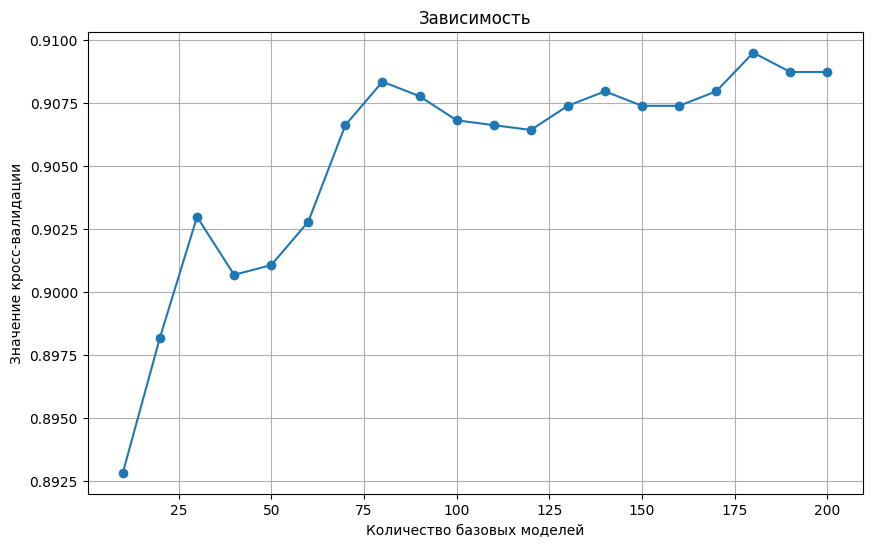

In [31]:
# Значения для числа базовых моделей
n_estimators_range = range(10, 201, 10)
cv_scores = []

# Подбор и оценка модели для каждого значения n_estimators
for n in n_estimators_range:
    bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=34,
                                    min_samples_leaf=4,
                                    class_weight={0:6,1:1}),
                            n_estimators=n, random_state=42)
    scores = cross_val_score(bag_clf, x_train, y_train, cv=3)
    cv_scores.append(scores.mean())

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Количество базовых моделей')
plt.ylabel('Значение кросс-валидации')
plt.title('Зависимость')
plt.grid(True)
plt.show()

На основе последних двух пунктов можно сделать ,что OPTUNA на 10 итерации подобрала нужные параметры ,а потом значения уже не сильно изменялись и отличались не сильно от лучших.В последнем пункте заметно, что с увеличением количества базовых моделей кросс-валидация растет.